In [1]:
import logging
from argparse import ArgumentParser
from multiprocessing import Pool
from pathlib import Path
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from laptrack import LapTrack
from skimage.measure import regionprops_table
from skimage.transform import downscale_local_mean
import itertools
from typing import Iterable, List, Any
from tqdm import tqdm


logging.basicConfig(level="INFO")



C:\Users\Nikon\Desktop\Code\Toettchlab-FBC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


def run_cellpose(infile, args):
    from cellpose import models
    from cellpose.io import imread

    model = models.CellposeModel(gpu=True, pretrained_model=args.model)

    stack = imread(infile)

    if args.channel is None:
        stack = [frame.astype(np.uint16) for frame in stack]

    else:
        stack = [frame[args.channel].astype(np.uint16) for frame in stack]

    if len(args.cellpose_norm) == 2:
        normalize = {"lowhigh": [args.cellpose_norm[0], args.cellpose_norm[1]]}

    else:
        normalize = True

    masks, _flows, _styles = model.eval(stack, batch_size=8, normalize=normalize)

    masks = np.stack(masks, axis=0)

    return masks


def process_masks(masks):
    collect_spots = []

    for t, frame in enumerate(masks):
        props = regionprops_table(frame, properties=["label", "area", "centroid"])

        df = pd.DataFrame(props)
        df["frame"] = t
        df = df.rename(columns={"centroid-0": "px_y", "centroid-1": "px_x"})

        print(df)

        collect_spots.append(df)

    spots_df = pd.concat([s for s in collect_spots], ignore_index=True)

    return spots_df


def track_spots(spots_df, args):
    max_distance = args.max_distance

    lt = LapTrack(
        metric="sqeuclidean",
        # The similarity metric for particles. See `scipy.spatial.distance.cdist` for allowed values.
        splitting_metric="sqeuclidean",
        merging_metric="sqeuclidean",
        gap_closing_metric="sqeuclidean",
        # the square of the cutoff distance for the "sqeuclidean" metric
        cutoff=max_distance**2,
        splitting_cutoff=False,  # or False for non-splitting case
        merging_cutoff=False,  # or False for non-merging case
        gap_closing_cutoff=max_distance**2,
        gap_closing_max_frame_count=2,
    )

    track_df, _split_df, _merge_df = lt.predict_dataframe(
        spots_df,
        coordinate_cols=[
            "px_x",
            "px_y",
        ],  # the column names for the coordinates
        frame_col="frame",  # the column name for the frame (default "frame")
        only_coordinate_cols=False,
    )

    track_df = track_df.rename(columns={"frame_y": "frame"})

    return track_df

def process_file(infile, in_dir, args):
    masks_dir = in_dir / "masks"
    tracks_dir = in_dir / "tracks"

    masks_outfile = masks_dir / f"{infile.stem}_masks.tif"
    tracks_outfile = tracks_dir / f"{infile.stem}_tracks.csv"

    print(masks_outfile)

    if masks_outfile.exists():
        cellpose_masks = tifffile.imread(masks_outfile)
        print(f"{masks_outfile.stem} exists: loading data")

    else:
        cellpose_masks = run_cellpose(str(infile), args)
        tifffile.imwrite(
            masks_outfile,
            cellpose_masks.astype(np.uint16),
            imagej=True,
            metadata={"axes": "tyx"},
        )

    if tracks_outfile.exists():
        tracks = pd.read_csv(tracks_outfile)
        print(f"{tracks_outfile.stem} exists: loading data")

    else:
        spots = process_masks(cellpose_masks)

        tracks = track_spots(spots, args)
        tracks.to_csv(tracks_outfile, index=False)

    return tracks

In [4]:
from types import SimpleNamespace

args = SimpleNamespace(
    dir = r"D:\Harrison\20260211_cellpose_workshop",  # the folder containing the tifs
    glob = "*.tif",  # segments all the .tif files in a directory
    cellpose_norm = [0, 1500], # lowest and highest pixel intensities, leave blank for no normalization
    model = "charlotte_e14_ktrT1_001",  # name of the cellpose model to load
    channel = 0, # channel to use for segmentation, None if single channel or no modification necessary
    max_distance = 20, # maximum distance to connect a cell between two frames during tracking
)

segmenting and tracking file 0/1: CC_mdck_ktr
D:\Harrison\20260211_cellpose_workshop\masks\CC_mdck_ktr_masks.tif
CC_mdck_ktr_masks exists: loading data
CC_mdck_ktr_tracks exists: loading data


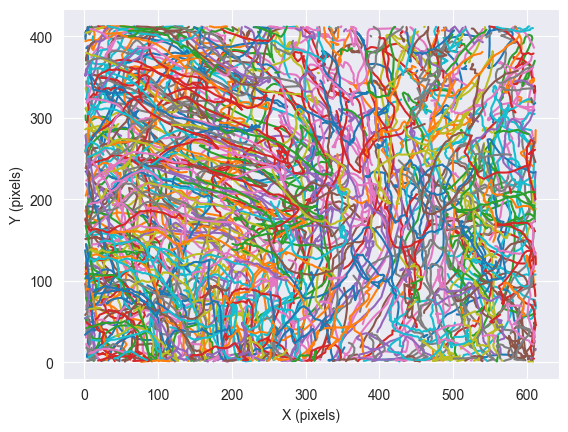

In [6]:

in_dir = Path(args.dir)

masks_dir = in_dir / "masks"
tracks_dir = in_dir / "tracks"

masks_dir.mkdir(exist_ok=True)
tracks_dir.mkdir(exist_ok=True)

files = list(in_dir.glob(args.glob))

for i, file in enumerate(files):
    print(f"segmenting and tracking file {i}/{len(files)}: {file.stem}")
    tracks = process_file(file, in_dir, args)

    for track_id, track in tracks.groupby("track_id"):
        plt.plot(track["px_x"], track["px_y"])
    plt.xlabel("X (pixels)")
    plt.ylabel("Y (pixels)")
    plt.show()

